### Common imports

In [1]:
%matplotlib inline
import os
import sys
import glob
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
from imageio import imread, imsave
import cv2

# Problem 1

Know $x_c, y_c, x_s, y_s, r$ and $z_c=1$ from the camera's look-at vector. Want to find $z_s$.

$$
\begin{align}
(x_s - x_c)^2 + (y_s - y_c)^2 + (z_s - z_c)^2 = r^2 \\
(z_s - 1)^2 = r^2 - (x_s - x_c)^2 - (y_s - y_c)^2 \\
z_s = \sqrt{r^2 - (x_s - x_c)^2 - (y_s - y_c)^2} + 1
\end{align}
$$

Hence, the direction of the light source, $(x_s, y_s, z_s)$ is:
$$(x_s, y_s, \sqrt{r^2 - (x_s - x_c)^2 - (y_s - y_c)^2} + 1)$$

# 2. Photometric Stereo

In [2]:
def LoadFaceImages(pathname, subject_name, num_images):
    """
    Load the set of face images.  
    The routine returns
        ambimage: image illuminated under the ambient lighting
        imarray: a 3-D array of images, h x w x Nimages
        lightdirs: Nimages x 3 array of light source directions
    """

    def load_image(fname):
        return np.asarray(Image.open(fname))

    def fname_to_ang(fname):
        yale_name = os.path.basename(fname)
        return int(yale_name[12:16]), int(yale_name[17:20])

    def sph2cart(az, el, r):
        rcos_theta = r * np.cos(el)
        x = rcos_theta * np.cos(az)
        y = rcos_theta * np.sin(az)
        z = r * np.sin(el)
        return x, y, z

    ambimage = load_image(
        os.path.join(pathname, subject_name + '_P00_Ambient.pgm'))
    im_list = glob.glob(os.path.join(pathname, subject_name + '_P00A*.pgm'))
    if num_images <= len(im_list):
        im_sub_list = np.random.choice(im_list, num_images, replace=False)
    else:
        print(
            'Total available images is less than specified.\nProceeding with %d images.\n'
            % len(im_list))
        im_sub_list = im_list
    im_sub_list.sort()
    imarray = np.stack([load_image(fname) for fname in im_sub_list], axis=-1)
    Ang = np.array([fname_to_ang(fname) for fname in im_sub_list])

    x, y, z = sph2cart(Ang[:, 0] / 180.0 * np.pi, Ang[:, 1] / 180.0 * np.pi, 1)
    lightdirs = np.stack([y, z, x], axis=-1)
    return ambimage, imarray, lightdirs

def plot_normal_map(normal_map):
    normal_viz = normal_map[:, ::, :]

    normal_viz = normal_viz + np.equal(np.sum(normal_viz, 2, 
    keepdims=True), 0.).astype(np.float32)*np.min(normal_viz)

    normal_viz = (normal_viz - np.min(normal_viz))/2.
    plt.axis('off')
    plt.imshow(normal_viz)

In [3]:
def save_outputs(subject_name, albedo_image, surface_normals):
    im = Image.fromarray((albedo_image*255).astype(np.uint8))
    im.save("%s_albedo.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,0]*128+128).astype(np.uint8))
    im.save("%s_normals_x.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,1]*128+128).astype(np.uint8))
    im.save("%s_normals_y.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,2]*128+128).astype(np.uint8))
    im.save("%s_normals_z.jpg" % subject_name)

#### Plot the albedo and the surface norms. 

In [4]:
def plot_albedo_and_surface_normals(albedo_image, surface_normals):
    """
    albedo_image: h x w matrix
    surface_normals: h x w x 3 matrix.
    """
    fig, axes = plt.subplots(1, 4, figsize=(10,2.5))
    ax = axes[0]
    ax.axis('off')
    ax.set_title('albedo')
    ax.imshow(albedo_image, cmap='gray')

    ax = axes[1]
    ax.axis('off')
    ax.set_title('X')
    im = ax.imshow(surface_normals[:,:,0], cmap='jet')
    ax = axes[2]
    ax.axis('off')
    ax.set_title('Y')
    im = ax.imshow(surface_normals[:,:,1], cmap='jet')
    ax = axes[3]
    ax.axis('off')
    ax.set_title('Z')
    im = ax.imshow(surface_normals[:,:,2], cmap='jet')

    fig.colorbar(im, ax=axes, fraction=0.02, aspect=15)

#### Plot the height map

In [5]:
def set_aspect_equal_3d(ax):
    """https://stackoverflow.com/questions/13685386"""
    """Fix equal aspect bug for 3D plots."""
    xlim = ax.get_xlim3d()
    ylim = ax.get_ylim3d()
    zlim = ax.get_zlim3d()
    from numpy import mean
    xmean = mean(xlim)
    ymean = mean(ylim)
    zmean = mean(zlim)
    plot_radius = max([
        abs(lim - mean_)
        for lims, mean_ in ((xlim, xmean), (ylim, ymean), (zlim, zmean))
        for lim in lims
    ])
    ax.set_xlim3d([xmean - plot_radius, xmean + plot_radius])
    ax.set_ylim3d([ymean - plot_radius, ymean + plot_radius])
    ax.set_zlim3d([zmean - plot_radius, zmean + plot_radius])

def display_3d(albedo_image, height_map, elev=20, azim=20):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca(projection='3d')
    ax.view_init(elev, azim)
    X = np.arange(albedo_image.shape[0])
    Y = np.arange(albedo_image.shape[1])
    X, Y = np.meshgrid(Y, X)
    H = np.flipud(np.fliplr(height_map))
    A = np.flipud(np.fliplr(albedo_image))
    A = np.stack([A, A, A], axis=-1)
    ax.xaxis.set_ticks([])
    ax.xaxis.set_label_text('Z')
    ax.yaxis.set_ticks([])
    ax.yaxis.set_label_text('X')
    ax.zaxis.set_ticks([])
    ax.yaxis.set_label_text('Y')
    surf = ax.plot_surface(
        H, X, Y, cmap='gray', facecolors=A, linewidth=0, antialiased=False)
    set_aspect_equal_3d(ax)

---
### Your implementation

## Problem 2

In [6]:
yale_subjects = ['yaleB01', 'yaleB02', 'yaleB05', 'yaleB07']
yale = {}

for subject in yale_subjects:
    ambimage, imarray, lightdirs = LoadFaceImages(
        'data/croppedyale/' + subject, subject, 64)
    yale[subject] = {
        'ambimage': ambimage,
        'imarray': imarray,
        'lightdirs': lightdirs
    }

I picked the first subject, 'yaleB01'. The shadows fall on different parts of the subject's face and reveal information about the shape of the parts in images with different lighting directions. For example, from the second image below, the bottom of the nose is lightened up while the nose bridge is in shadows when the light comes from the bottom.

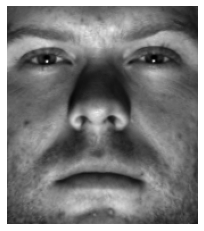

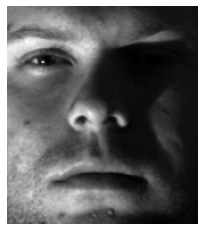

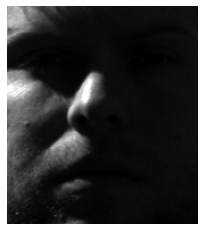

In [7]:
for i in [0, 5, 20, 30]:
    plt.imshow(yale['yaleB01']['imarray'][:, :, i], cmap='gray')
    plt.axis('off')
    plt.show()

## Problem 3

In [8]:
def preprocess(ambimage, imarray):
    """
    preprocess the data: 
        1. subtract ambient_image from each image in imarray.
        2. make sure no pixel is less than zero.
        3. rescale values in imarray to be between 0 and 1.
    Inputs:
        ambimage: h x w
        imarray: h x w x Nimages
    Outputs:
        processed_imarray: h x w x Nimages
    """
    processed = imarray - ambimage[:, :, np.newaxis]
    processed = np.where(processed < 0, 0, processed).astype(float)
    processed /= 255
    return processed

In [9]:
for subject in yale_subjects:
    processed = preprocess(
        yale[subject]['ambimage'],
        yale[subject]['imarray']
    )
    yale[subject]['processed'] = processed

The preprocessed images don't look too different from the ones we showed above.

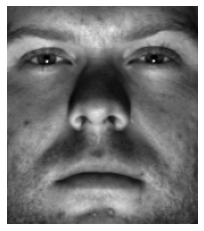

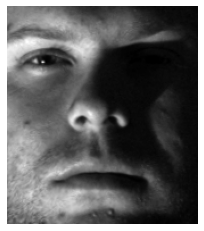

In [10]:
for i in [0, 5, 20, 30]:
    plt.imshow(yale['yaleB01']['processed'][:, :, i], cmap='gray')
    plt.axis('off')
    plt.show()

## Problem 4

In [11]:
def photometric_stereo(imarray, light_dirs):
    """
    Inputs:
        imarray:  h x w x Nimages
        light_dirs: Nimages x 3
    Outputs:
        albedo_image: h x w
        surface_norms: h x w x 3
    """
    height, width = imarray.shape[:2]
    albedo_image = np.empty((height, width))
    surface_norms = np.empty((height, width, 3))
    for h in range(height):
        for w in range(width):
            intensity = imarray[h, w, :] # Nx1
            G = np.linalg.lstsq(light_dirs, intensity, rcond=None)[0]
            albedo = np.linalg.norm(G)
            albedo_image[h, w] = albedo
            surface_norms[h, w] = G / albedo
    return albedo_image, surface_norms

In [12]:
for subject in yale_subjects:
    albedo_image, surface_norms = photometric_stereo(
        yale[subject]['processed'],
        yale[subject]['lightdirs']
    )
    yale[subject]['albedo'] = albedo_image
    yale[subject]['surface_norms'] = surface_norms

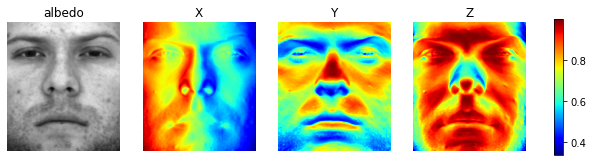

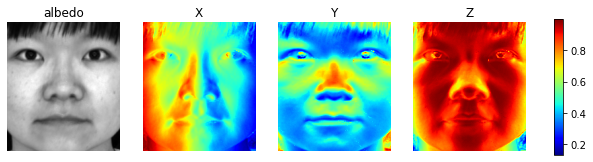

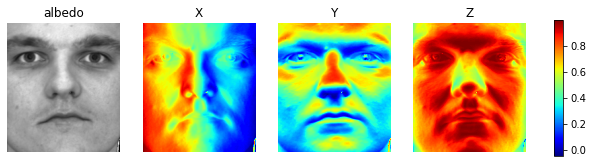

In [13]:
for subject in yale_subjects:
    plot_albedo_and_surface_normals(
        yale[subject]['albedo'],
        yale[subject]['surface_norms']
    )

## Problem 5

$$
f(x, y) = \sum_{s=0}^{x} f_x(s, 0) + \sum_{t=0}^y f_y(x, t)
$$

In [14]:
def get_surface(surface_normals):
    """
    Inputs:
        surface_normals:h x w x 3
    Outputs:
        height_map: h x w
    """
    height, width = surface_normals.shape[:2]
    height_map = np.empty((height, width))
    f_x = surface_normals[:, :, 0] / surface_normals[:, :, 2]
    f_y = surface_normals[:, :, 1] / surface_normals[:, :, 2]
    
    # row then column
    f_x_sum = 0 # cache computations
    for w in range(width):
        f_y_sum = 0
        f_x_sum += f_x[0, w]
        for h in range(height):
            f_y_sum += f_y[h, w]
            height_map[h, w] = f_x_sum + f_y_sum
    return height_map

In [15]:
for subject in yale_subjects:
    height_map = get_surface(yale[subject]['surface_norms'])
    yale[subject]['height_map'] = height_map

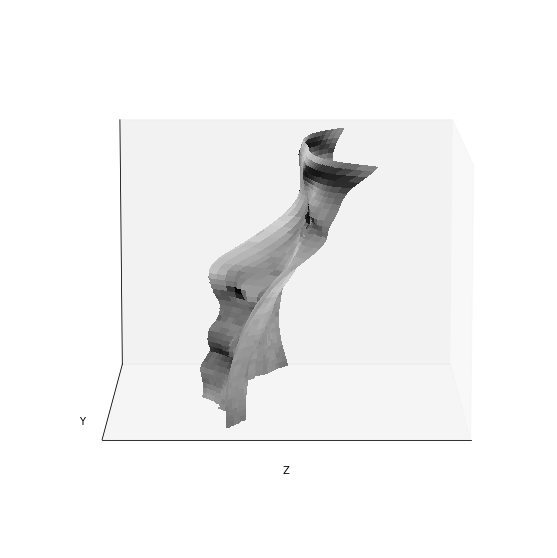

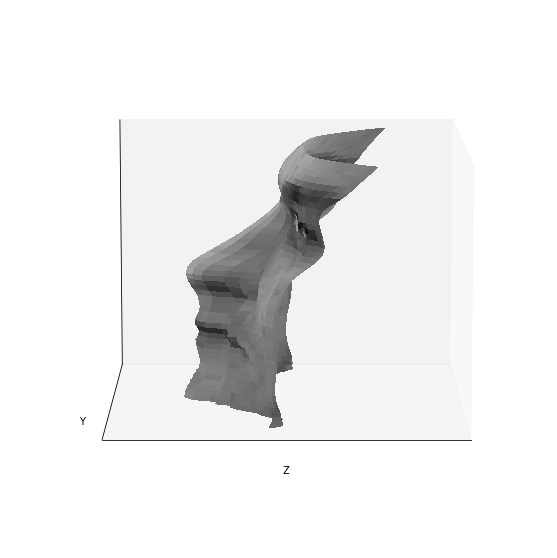

In [16]:
for subject in yale_subjects:
    display_3d(
        yale[subject]['albedo'],
        yale[subject]['height_map'],
        elev=10, azim=90
    )

### Main function

'\nif save_flag:\n    save_outputs(subject_name, albedo_image, surface_normals)\n'

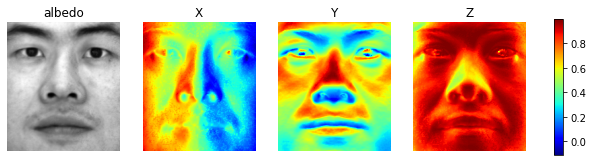

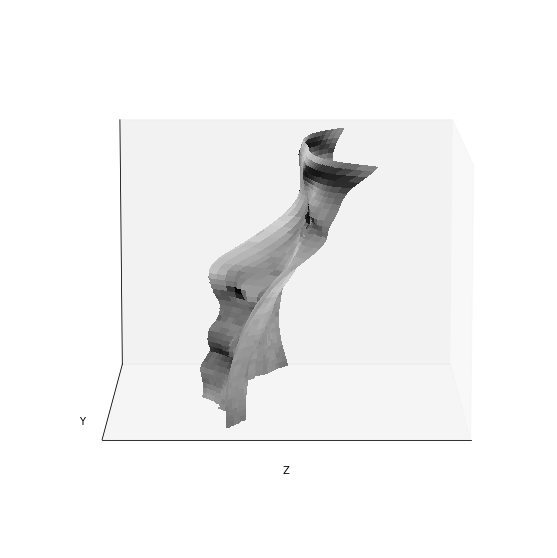

In [17]:
root_path = 'data/croppedyale/'
subject_name = 'yaleB02'

integration_method = 'average'
save_flag = True

full_path = '%s%s' % (root_path, subject_name)
ambient_image, imarray, light_dirs = LoadFaceImages(full_path, subject_name,
                                                    64)


processed_imarray = preprocess(ambient_image, imarray)

albedo_image, surface_normals = photometric_stereo(processed_imarray,
                                                   light_dirs)


height_map = get_surface(surface_normals)

plot_albedo_and_surface_normals(albedo_image, surface_normals)
display_3d(albedo_image, height_map, elev=10, azim=90)
"""
if save_flag:
    save_outputs(subject_name, albedo_image, surface_normals)
"""

In [18]:
plot_normal_map(surface_normals)

## Problem 6

The Yale Face dataset violates at least the following assumptions:
   - It has specularity on the nose, while we are assuming simplistic reflectance and lighting model
   - It has cast shadows around the nose, while we are assuming no shadows

(-0.5, 167.5, 191.5, -0.5)

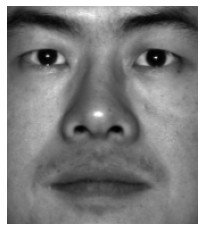

In [19]:
# an example of specularity on the nose
plt.imshow(yale['yaleB02']['imarray'][:, :, 0], cmap='gray')
plt.axis('off')

In [20]:
# an example of cast shadow under the nose
plt.imshow(yale['yaleB02']['imarray'][:, :, 3], cmap='gray')
plt.axis('off')

(-0.5, 167.5, 191.5, -0.5)

I attempt to improve the results for the subject 'yaleB05'. Using all of the imput images result in a height map that is a little spiky around the eyes, nose, and mouth.

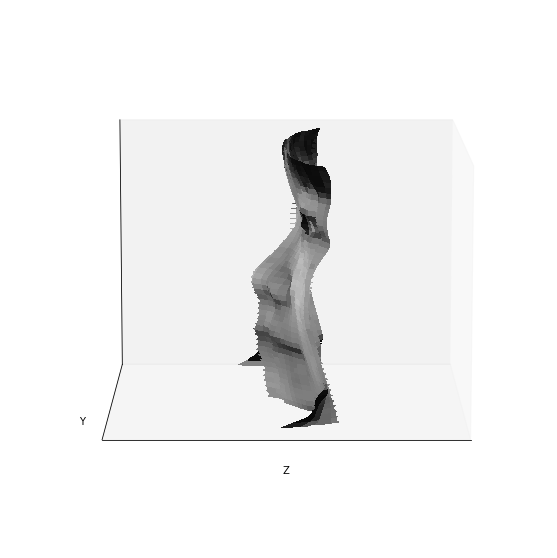

In [21]:
subject = 'yaleB05'
display_3d(
    yale[subject]['albedo'],
    yale[subject]['height_map'],
    elev=10, azim=90
)

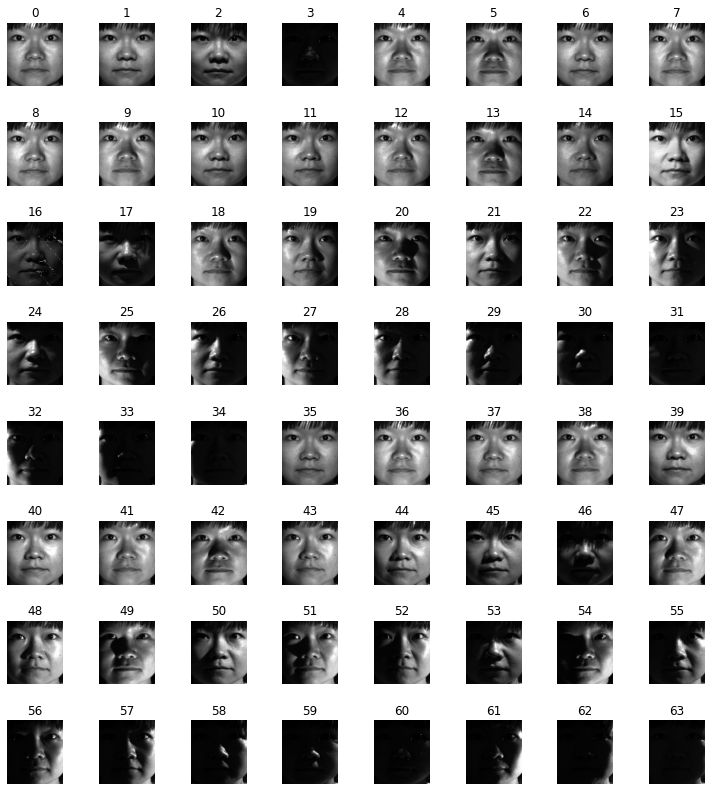

In [22]:
# select a subjset and pick a subset of images
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(14, 14))
grid = ImageGrid(fig, 111, nrows_ncols=(8, 8), axes_pad=0.5)

for i in range(64):
    ax = grid[i]
    im = yale[subject]['processed'][:, :, i]
    ax.imshow(im, cmap='gray')
    ax.set_title(str(i))
    ax.axis('off')

Let's remove the images that appear too dark to be useful.

In [23]:
indices = [3, 16, 17] + list(range(27, 35)) + list(range(56, 64))
processed_imarray = np.delete(yale[subject]['processed'], indices, axis=2)
light_dirs = np.delete(yale[subject]['lightdirs'], indices, axis=0)

In [24]:
processed_imarray.shape

(192, 168, 45)

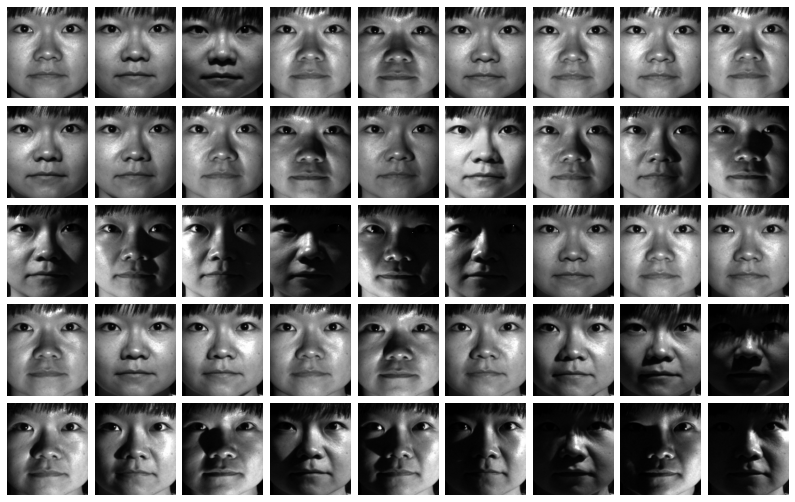

In [25]:
fig = plt.figure(figsize=(14, 14))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 9), axes_pad=0.1)

for i in range(processed_imarray.shape[-1]):
    ax = grid[i]
    im = processed_imarray[:, :, i]
    ax.imshow(im, cmap='gray')
    ax.axis('off')

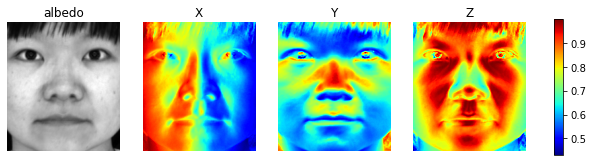

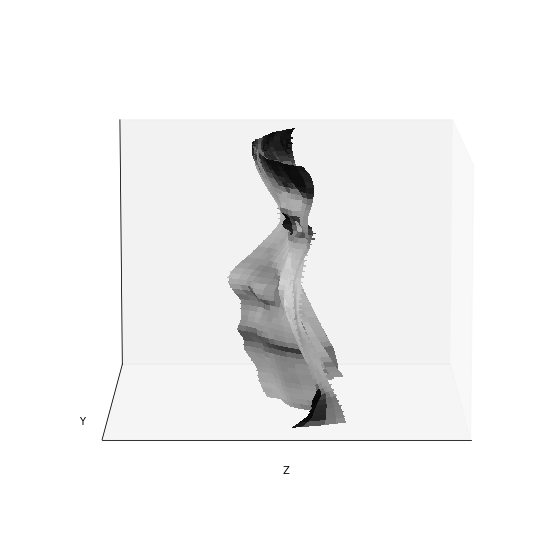

In [26]:
albedo_image, surface_normals = photometric_stereo(processed_imarray,
                                                   light_dirs)

height_map = get_surface(surface_normals)

plot_albedo_and_surface_normals(albedo_image, surface_normals)
display_3d(albedo_image, height_map, elev=10, azim=90)

Although the shape looks a little less realistic now as the nose and mouth is protruding too much (even for a child's face), we did seem to have removed the spikes around the eyes, nose, and mouth in the height map.

# 3. Denoising

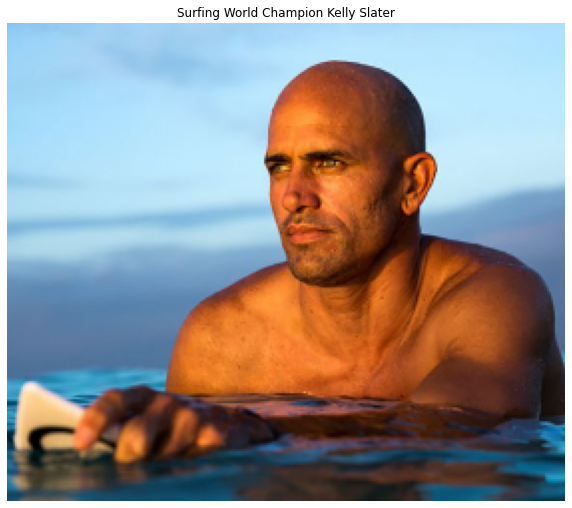

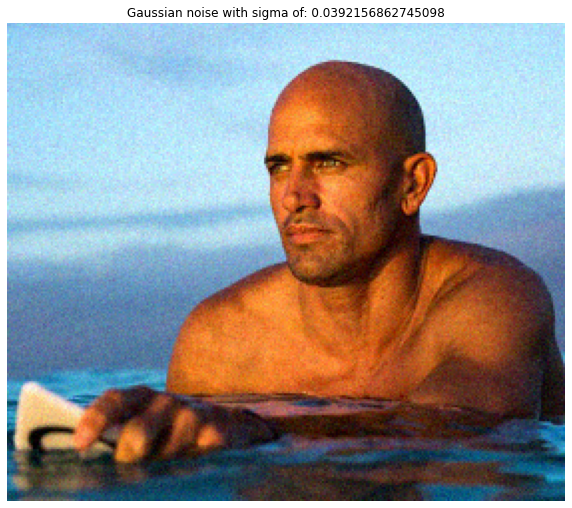

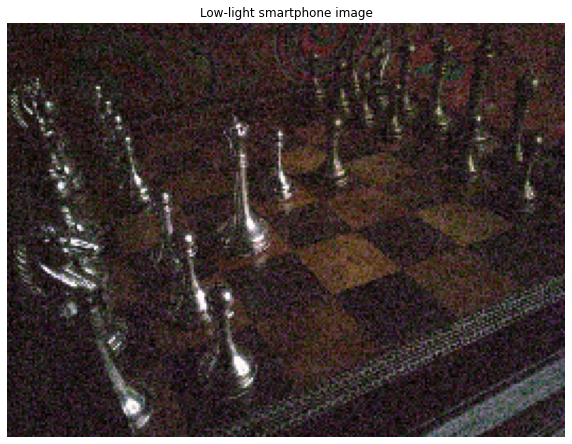

In [27]:
slater_image = imread('data/slater.jpg')/255.

# Note: we are reducing the size for faster processing.
slater_image = cv2.resize(slater_image, (280, 240))

sigma = 10/255.

plt.figure(figsize=(10,20))
plt.axis('off')
plt.imshow(slater_image)

def noising_model(image, sigma):
    noise = np.random.normal(0, sigma, (image.shape))
    return image + noise

noisy_image = noising_model(slater_image, sigma=sigma)

# need to bring us better into range
noisy_image = np.clip(noisy_image, 0, 1)

plt.title("Surfing World Champion Kelly Slater")
plt.figure(figsize=(10,20))
plt.axis('off')
plt.title("Gaussian noise with sigma of: {}".format(sigma))
plt.imshow(noisy_image)

# "real" noise image
chess_raw = imread("data/chess.png")

chess_noisy = cv2.resize(chess_raw, (int(chess_raw.shape[1]/4), int(chess_raw.shape[0]/4)))/255.
plt.figure(figsize=(10,20))
plt.axis('off')
plt.title("Low-light smartphone image")
plt.imshow(chess_noisy)

## Problem 7 and 8

In [28]:
import scipy.ndimage
from scipy.signal import medfilt2d

In [29]:
# Implement the two filters from scratch

def median_filter(data, filter_size):
    # filter each channel
    red = medfilt2d(data[:, :, 0], filter_size)
    green = medfilt2d(data[:, :, 1], filter_size)
    blue = medfilt2d(data[:, :, 2], filter_size)
    ret = np.dstack([red, green, blue])
    return ret
    
def mean_filter(data, filter_size):
    kernel = np.full((filter_size, filter_size), 1. / filter_size**2)
    # filter each channel
    red = scipy.ndimage.filters.convolve(data[:, :, 0], kernel)
    green = scipy.ndimage.filters.convolve(data[:, :, 1], kernel)
    blue = scipy.ndimage.filters.convolve(data[:, :, 2], kernel)
    ret = np.dstack([red, green, blue])
    return ret

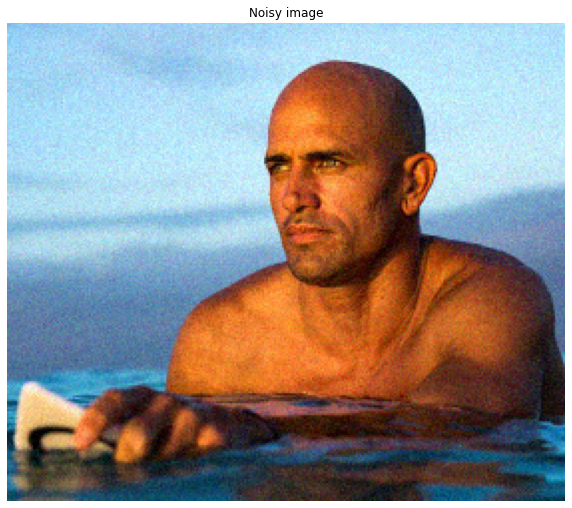

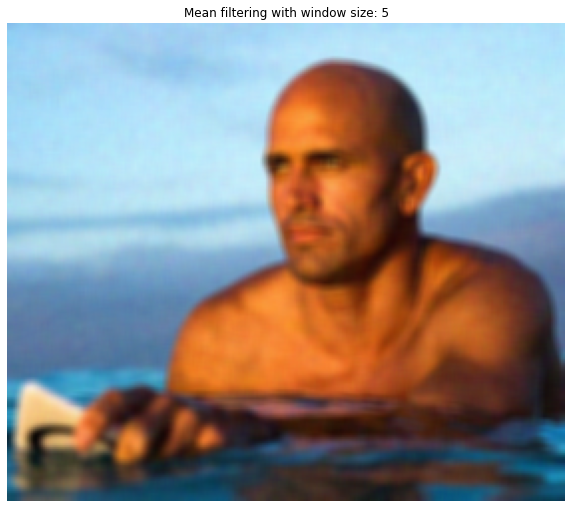

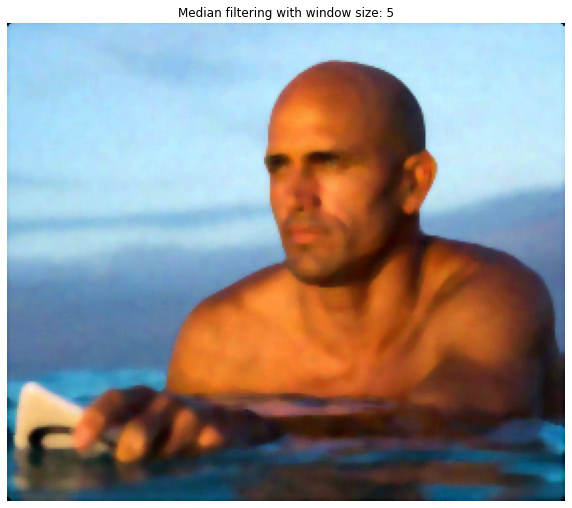

In [30]:
window_size = 5

mean_filtered_image = mean_filter(noisy_image, window_size)
median_filtered_image = median_filter(noisy_image, window_size)

plt.figure(figsize=(10,20))
plt.title("Noisy image")
plt.imshow(noisy_image)
plt.axis('off')
plt.figure(figsize=(10,20))
plt.axis('off')
plt.title("Mean filtering with window size: {}".format(window_size))
plt.imshow(mean_filtered_image)
plt.figure(figsize=(10,20))
plt.axis('off')
plt.title("Median filtering with window size: {}".format(window_size))
plt.imshow(median_filtered_image)

### Problem 7

A larger kernel size reduces the amount of noise but also blurs out the details in the image. The mean filter doesn't do a good job of preserving details but a decent job of removing noise when the filter size is larger than 5.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


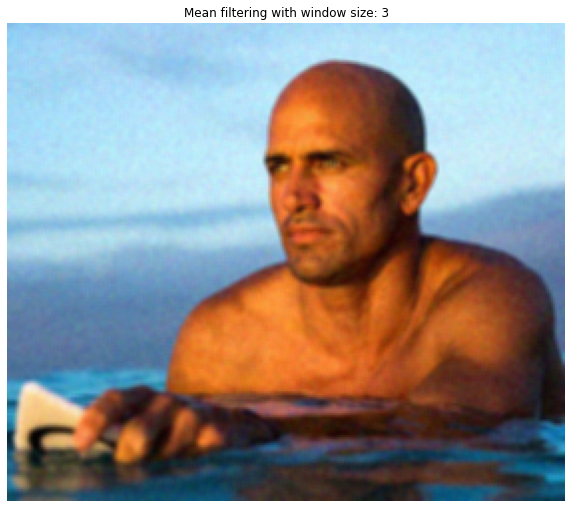

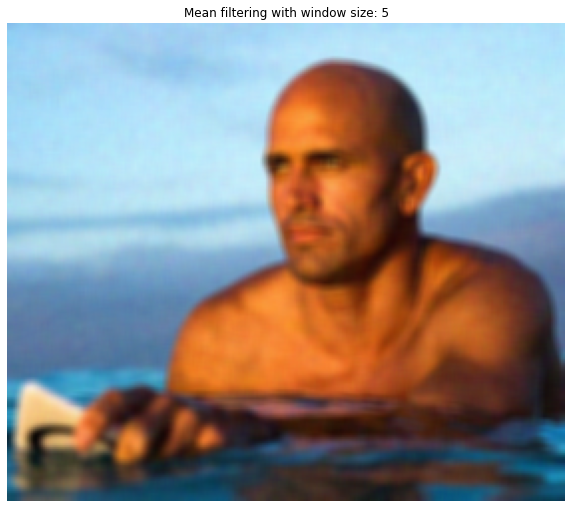

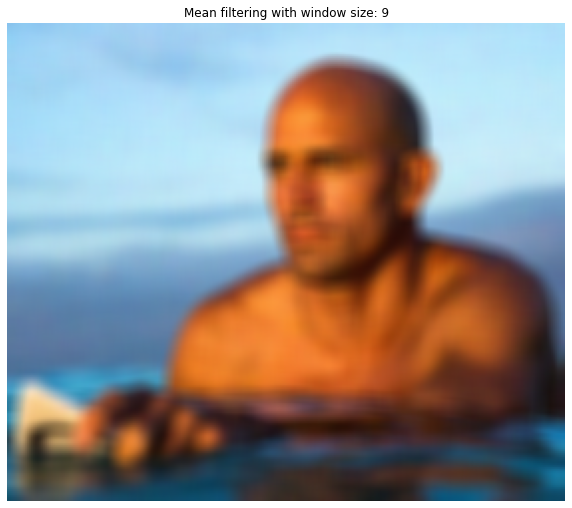

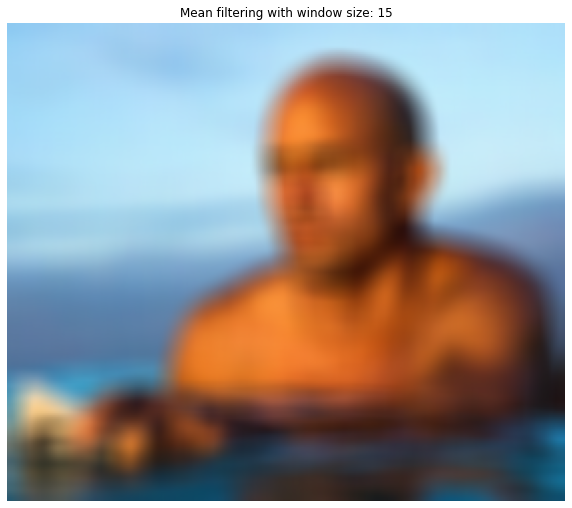

In [31]:
for window_size in [3, 5, 9, 15]:
    im = mean_filter(noisy_image, window_size)
    plt.figure(figsize=(10,20))
    plt.axis('off')
    plt.title("Mean filtering with window size: {}".format(window_size))
    plt.imshow(im)

### Problem 8

Similar to the mean filter, the larger the kernel size, the more noise removed but also the more details blurred. Compared to the mean filter, the median filter does a better job of preserving details.

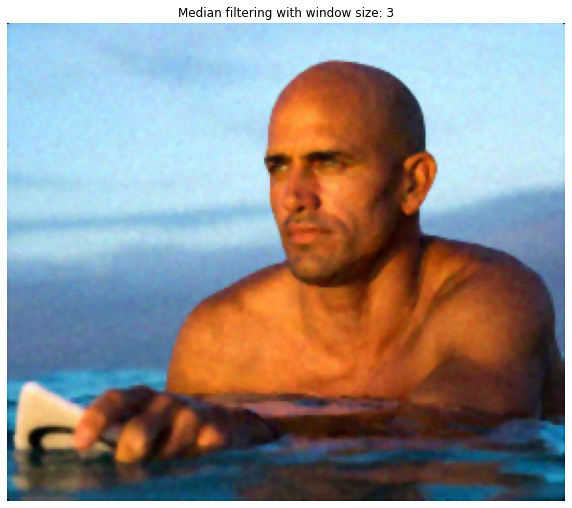

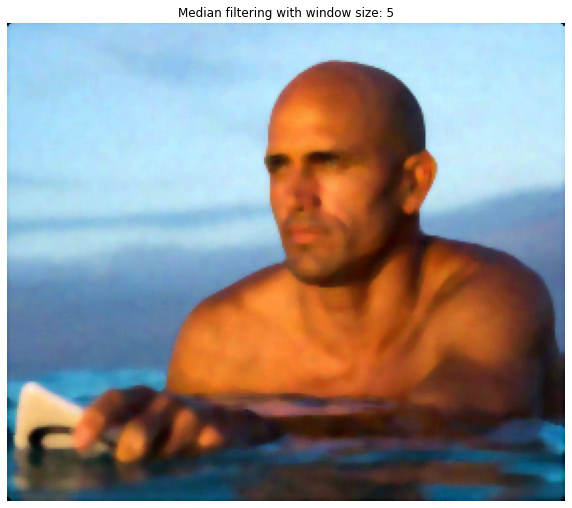

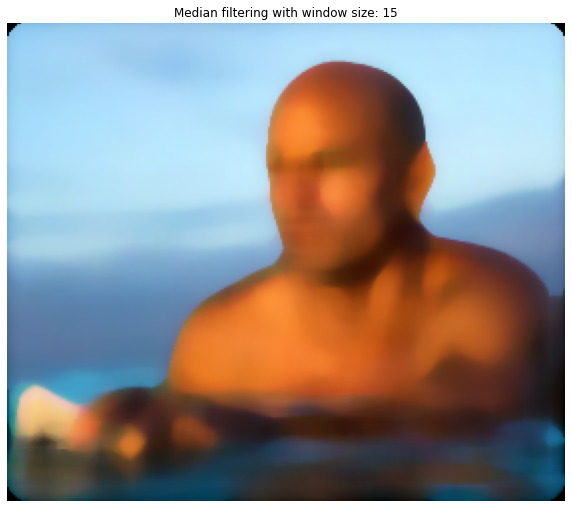

In [32]:
for window_size in [3, 5, 9, 15]:
    im = median_filter(noisy_image, window_size)
    plt.figure(figsize=(10,20))
    plt.axis('off')
    plt.title("Median filtering with window size: {}".format(window_size))
    plt.imshow(im)

## Problem 9

In [33]:
def mse(noisy_image, denoised_image):
    ret = ((noisy_image - denoised_image) ** 2).mean()
    return ret

def psnr(noisy_image, denoised_image):
    ret = 20 * np.log10(255 / np.sqrt(mse(noisy_image, denoised_image)))
    return ret

In [34]:
print("PSNR for the noisy image: {}".format(psnr(slater_image, noisy_image)))
print("PSNR for the mean filtered image: {}".format(psnr(slater_image, mean_filtered_image)))
print("PSNR for the median filtered image: {}".format(psnr(slater_image, median_filtered_image)))

PSNR for the noisy image: 76.50061734950779
PSNR for the mean filtered image: 77.530093702601
PSNR for the median filtered image: 79.09757857681095


The higher the PSNR, the better quality of the reconstructed image. By the PSNR metric, the median filter is better than the mean filter. It does correpsond to my subjective notion of image quality, in that a more blurry image is of lower quality, and a image preserving a majority of the details (especially the edges) is of higher quality.

## Problem 10 and 11

From the non-local means paper linked to in the problem set:

$$
w(p, q) = \exp\{-\frac{\max(d^2 - 2 \sigma^2, 0)}{h^2}\}
$$

To make the output the same size as the original, we may also fill in the edges (skipped by the serve domain) with the values from the original image. This will make it easier for us to compare different PSNR values achieved by different methods.

In [35]:
def compute_weight(d, h=1, sigma=20/255.):
    ret = np.exp(-max(d**2 - 2 * sigma**2, 0) / h**2)
    return ret

def bilateral_filter(image, sigma=20/255., h=1):
    
    # hint for "naive" for-loop based implementation
    
    n1, n2, c = image.shape

    Z = np.zeros((n1, n2, *[1] * (image.ndim - 2)))
    x = np.zeros(image.shape)

    s1 = s2 = 2 # search window domain
    p1 = p2 = 1 # patch domain; patch size is (2p1 + 1) x (2p2 + 1)

    for i in range(s1, n1-s1-p1):
        for j in range(s2, n2-s2-p2):
            for k in range(-s1, s1 + 1):
                w_k = compute_weight(k, h, sigma) # cache computation
                for l in range(-s2, s2 + 1):
                    w = (w_k * compute_weight(l, h, sigma)
                         * compute_weight(
                             np.linalg.norm(image[i, j] - image[i + k, j + l]),
                             h, sigma
                         ))
                    Z[i, j] += w
                    x[i, j] += w * image[i + k, j + l]
            if Z[i, j] == 0:
                x[i, j] = 0
            else:
                x[i, j] /= Z[i, j]
            
    # use the original image value for the those outside the search window domain
    x[:s1] = image[:s1]
    x[n1-s1-p1:] = image[n1-s1-p1:]
    x[:, :s2] = image[:, :s2]
    x[:, n2-s2-p2:] = image[:, n2-s2-p2:]
    
    return x

As mentioned in the lecture, we compute patch distance SSD in the $L^*a^*b$ color space.

In [36]:
from skimage import color

In [37]:
def nlmeans_filter(image, sigma=20/255., h=1):
    # hint: implementation will be very similar to bilateral filter
    # can reuse most of your implementation
    n1, n2, c = image.shape

    Z = np.zeros((n1, n2, *[1] * (image.ndim - 2)))
    x = np.zeros(image.shape)

    s1 = s2 = 2 # search window domain, i.e., neighborhood
    p1 = p2 = 1 # patch domain; patch size is (2p1 + 1) x (2p2 + 1)

    for i in range(s1+p1, n1-s1-p1):
        for j in range(s2+p2, n2-s2-p2):
            patch_i = image[
                i - p1 : i + p1, 
                j - p2 : j + p2
            ]
#             patch_i = color.rgb2lab(patch_i)
            for k in range(-s1, s1 + 1):
                for l in range(-s2, s2 + 1):
                    patch_j = image[
                        i + k - p1 : i + k + p1,
                        j + l - p2 : j + l + p2
                    ]
#                     patch_j = color.rgb2lab(patch_j)
                    ssd = ((patch_i - patch_j) ** 2).sum()
                    w = compute_weight(ssd, h, sigma)
                    Z[i, j] += w
                    x[i, j] += w * image[i + k, j + l]
            if Z[i, j] == 0:
                x[i, j] = 0
            else:
                x[i, j] /= Z[i, j]
            
    # use the original image value for the those outside the search window domain
    x[:s1+p1] = image[:s1+p1]
    x[n1-s1-p1:] = image[n1-s1-p1:]
    x[:, :s2+p2] = image[:, :s2+p2]
    x[:, n2-s2-p2:] = image[:, n2-s2-p2:]
    
    return x

3.0 16.599332571029663
PSNR for the bilateral filtered image: 81.61970738241536
PSNR for the NLM filtered image: 79.54226038518387


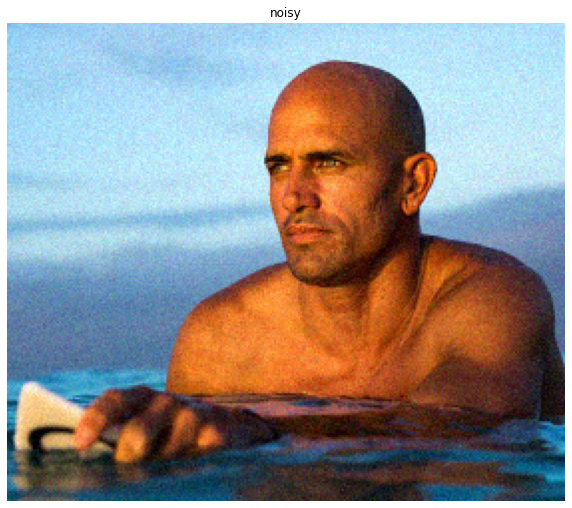

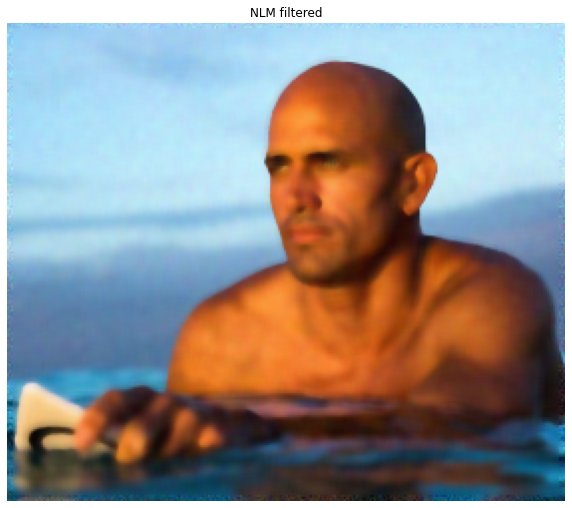

In [38]:
import time

start = time.time()

plt.figure(figsize=(10,20))
plt.axis('off')
plt.title("noisy")
plt.imshow(noisy_image)

bilateral_filtered_image = bilateral_filter(noisy_image, sigma=10/255.)
nlmeans_filtered_image = nlmeans_filter(noisy_image, sigma=10/255.)

plt.figure(figsize=(10,20))
plt.axis('off')
plt.title("Bilateral filtered")
plt.imshow(bilateral_filtered_image)

plt.figure(figsize=(10,20))
plt.axis('off')
plt.title("NLM filtered")
plt.imshow(nlmeans_filtered_image)

elapsed = (time.time() - start)

hours, rem = divmod(elapsed, 3600)
minutes, seconds = divmod(rem, 60)
print(minutes, seconds)

# Note: your numbers can be different depending on implementation and hyperparameters
print("PSNR for the bilateral filtered image: {}".format(psnr(slater_image, bilateral_filtered_image)))
print("PSNR for the NLM filtered image: {}".format(psnr(slater_image, nlmeans_filtered_image)))

In [ ]:
# Example of denoising for the chess image with unknown noise.  Feel free to play with the sigma "guess"
# and other parameters to see if you can improve the qualitative reconstruction
# Reducing the size of the image for faster processing

chess_raw = imread("data/chess.png")

chess_noisy = cv2.resize(chess_raw, (int(chess_raw.shape[1]/4), int(chess_raw.shape[0]/4)))/255.
plt.figure(figsize=(10,20))
plt.axis('off')
plt.title("Low-light smartphone image")
plt.imshow(chess_noisy)

mean_filtered_chess = mean_filter(chess_noisy, 3)
bilateral_filtered_chess_20 = bilateral_filter(chess_noisy, sigma=20/255.)
bilateral_filtered_chess_40 = bilateral_filter(chess_noisy, sigma=40/255.)

plt.figure(figsize=(10,20))
plt.axis('off')
plt.title("Mean filtered image")
plt.imshow(mean_filtered_chess)

plt.figure(figsize=(10,20))
plt.axis('off')
plt.title("Bilateral filtered image (sigma=20/255)")
plt.imshow(bilateral_filtered_chess_20)

plt.figure(figsize=(10,20))
plt.axis('off')
plt.title("Bilateral filtered image (sigma=40/255)")
plt.imshow(bilateral_filtered_chess_40)

### Problem 10

Quantitatively, the non-local means filter achieves a better PSNR than either the mean or the median filter. Qualitatively the image also looks better: most noise is removed and most details (especially the edges and definition of shadows in the image) are kept. It does a pretty decent job of preserving details.

### Problem 11

Quantitatively, the bilateral filter achieves a better PSNR than either the mean or the median filter. Qualitatively the image also looks better: most noise is removed and most details (especially the edges and definition of shadows in the image) are kept. 